In [1]:
from langgraph.graph import StateGraph, START, END, add_messages
from langgraph.types import Command, interrupt
from typing import TypedDict, Annotated, List
from langgraph.checkpoint.memory import MemorySaver
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
import uuid
from langchain_core.messages import HumanMessage
from IPython.display import Image, display

In [2]:
llm=ChatGroq(model="llama-3.1-8b-instant")

In [3]:
persistent_state={}

In [4]:
class State(TypedDict):
    linkedin_topic: str
    generated_post: Annotated[List[str], add_messages]
    human_feedback: Annotated[List[str], add_messages]

In [5]:
def model(state: State):
    """
        Here, we're using the LLM to generate a LinkedIn Post with human feedback incorporated
    """
    
    # print("[model] Generating content")
    linkedin_topic=state['linkedin_topic']
    feedback= state['human_feedback'][-1].content if state['human_feedback'] else "No Feedback Yet"

    # Here we define the prompt
    prompt=f"""

    LinkedIn Topic: {linkedin_topic}
    Human Feedback: {feedback}

    Generate a structured and well written LinkedIn post based on the given topic

    Consider previous human feedback to refine the response
    """
    response=llm.invoke(input=[
        SystemMessage(content="You are an expert LinkedIn content writer"),
        HumanMessage(content=prompt)
    ])

    generated_linkedin_post=response.content

    # print(f"Model Node generated post:\n {generated_linkedin_post}")

    state['generated_post']=[AIMessage(content=generated_linkedin_post)]
    # state['human_feedback']=[AIMessage(content=feedback)]
    
    model_payload={
        "generated_post": [AIMessage(content=generated_linkedin_post)],
        "human_feedback": [feedback]
    }
    # print(f"Present State: {model_payload}\n")
    persistent_state['state']=state
    return state

In [6]:
def human_node(state:State):
    """
        Human Intervention node - loops back to model unless input is done
    """
    # print("\n [human_node] awaiting human feedback...")
    generated_post=state["generated_post"][-1]
    
    # Interrupt to get user feedback
    user_feedback=interrupt(
        value={
            "generated_post":generated_post,
            "message":"Provide feedback or type 'done' to finish"
        }
    )

    # print(f"[human_node] Received human feedback: {user_feedback}")

    # If user types "done", transition to END node
    if user_feedback.casefold()=="done":
        return Command(
                    update={"human_feedback":[AIMessage(content="Finalised")]},
                    goto="end_node"
                )
    else:
        return Command(
                    update={"human_feedback": [AIMessage(content=user_feedback)]},
                    goto="model"
                )

In [7]:
def end_node(state:State):
    """
     Final Node
    """
    # print("\n[end_node] Process finished")
    # print(f"Final Generated Post: {state['generated_post'][-1].content}")
    # print(f"Final Human feedback: {state['human_feedback'][-1].content}")
    return {
        "generated_post":state["generated_post"][-1].content,
        "human_feedback":state["human_feedback"][-1].content
    }    

In [8]:
graph=StateGraph(state_schema=State)

In [9]:
graph.add_node(node="model",action=model)

In [10]:
graph.add_node(node="human_node",action=human_node)

In [11]:
graph.set_entry_point(key="model")

In [12]:
graph.add_node(node="end_node",action=end_node)

In [13]:
graph.add_edge(start_key=START,end_key="model")

In [14]:
graph.add_edge(start_key="model",end_key="human_node")

In [15]:
graph.set_finish_point(key="end_node")

In [16]:
checkpointer=MemorySaver()

In [17]:
app=graph.compile(checkpointer=checkpointer)

In [18]:
thread_config={
    "configurable":{"thread_id":uuid.uuid4()}
    }

In [19]:
app.get_graph().print_ascii()

+-----------+  
| __start__ |  
+-----------+  
       *       
       *       
       *       
  +-------+    
  | model |    
  +-------+    
       *       
       *       
       *       
+------------+ 
| human_node | 
+------------+ 
       *       
       *       
       *       
  +---------+  
  | __end__ |  
  +---------+  


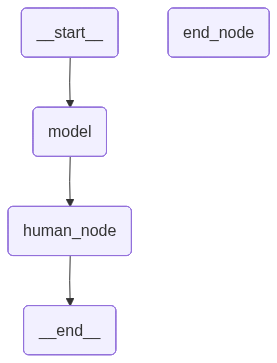

In [20]:
display(Image(data=app.get_graph().draw_mermaid_png()))

In [21]:
linkedin_topic=input("Enter your Linkedin topic: ")
initial_state={
    "linkedin_topic":linkedin_topic,
    "generated_post":[],
    "human_feedback":[]
}

In [22]:
initial_state

{'linkedin_topic': 'Venezuela and Oil',
 'generated_post': [],
 'human_feedback': []}

In [24]:
for chunk in app.stream(input=initial_state, config=thread_config):
    print(f"Chunk: {chunk}")
    for node_id, value in chunk.items():
        # If we reach an interrupt, continously ask for human feedback
        if (node_id=="__interrupt__"):
            while True:
                user_feedback=input("Provide feedback (or type 'done' when finished): ")

                # Resume the graph execution with the user's feedback
                response=app.invoke(input=Command(resume=user_feedback),config=thread_config)
                print(f"response:{response}")
                # Exit loop if user says done
                if user_feedback.lower()=="done":
                    break

Chunk: {'model': {'linkedin_topic': 'Venezuela and Oil', 'generated_post': [AIMessage(content="**Title:** The Venezuela Oil Conundrum: Lessons for the Global Energy Market\n\n**Introduction:**\nAs the world's largest oil reserves holder, Venezuela has long been a dominant player in the global energy market. However, its current situation serves as a stark reminder of the complexities and risks associated with relying heavily on oil exports. In this post, we'll delve into the Venezuela oil conundrum and explore the lessons that can be learned for the global energy market.\n\n**The Venezuela Oil Story:**\nVenezuela's oil reserves are estimated to be around 302 billion barrels, making it the country with the largest oil reserves globally. However, the country's oil industry has been plagued by mismanagement, corruption, and declining production levels. The country's oil production has declined significantly in recent years, from a peak of 3.3 million barrels per day (mb/d) in 1997 to just

In [25]:
persistent_state

{'state': {'linkedin_topic': 'Venezuela and Oil',
  'generated_post': [AIMessage(content="**Title:** Unpacking the Complex Relationship Between Venezuela, Oil, and the US: What's at Stake?\n\n**Introduction:**\n\nAs the world's fifth-largest oil producer, Venezuela has long been a significant player in the global energy landscape. However, the country's tumultuous history, coupled with the US's long-standing interest in its oil resources, has created a complex web of relationships that continue to shape the region's politics and economy. In this post, we'll delve into the intricacies of Venezuela's oil industry, the US's involvement, and what this means for the future of energy production and global politics.\n\n**The Rise and Fall of Venezuela's Oil Industry:**\n\nVenezuela has been a major oil producer since the early 20th century, with the country's oil reserves estimated to be around 302 billion barrels – the largest in the world. However, over the years, the industry has faced sig

In [46]:
from langgraph.graph import StateGraph, START, END, add_messages
from typing import TypedDict, Annotated, List, Literal
from langgraph.checkpoint.memory import MemorySaver
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
import uuid

# Setup LLM
llm = ChatGroq(model="llama-3.1-8b-instant")

class State(TypedDict):
    linkedin_topic: str
    generated_post: Annotated[List[str], add_messages]
    human_feedback: Annotated[List[str], add_messages]

def model(state: State):
    """
    Generates a LinkedIn Post with human feedback incorporated
    """
    linkedin_topic = state['linkedin_topic']
    # Get the last feedback if available
    feedback = state['human_feedback'][-1].content if state['human_feedback'] else "No Feedback Yet"

    prompt = f"""
    LinkedIn Topic: {linkedin_topic}
    Human Feedback: {feedback}

    Generate a structured and well written LinkedIn post based on the given topic.
    Consider previous human feedback to refine the response.
    """
    
    response = llm.invoke(input=[
        SystemMessage(content="You are an expert LinkedIn content writer"),
        HumanMessage(content=prompt)
    ])

    return {"generated_post": [AIMessage(content=response.content)]}

def human_node(state: State):
    """
    This node acts as a landing point. 
    The graph pauses BEFORE this node runs. 
    When it runs, the state has already been updated with user feedback.
    """
    pass

def should_continue(state: State) -> Literal["end_node", "model"]:
    """
    Conditional logic to determine the next step based on feedback
    """
    last_feedback = state["human_feedback"][-1].content
    
    if last_feedback.lower() == "done":
        return "end_node"
    else:
        return "model"

def end_node(state: State):
    """
    Final Node
    """
    return {
        "generated_post": [AIMessage(content="Process Finalized")],
        # We don't strictly need to return anything here if we just want the final state
    }    

# --- Graph Definition ---
graph = StateGraph(State)

graph.add_node("model", model)
graph.add_node("human_node", human_node)
graph.add_node("end_node", end_node)

# Flow
graph.add_edge(START, "model")
graph.add_edge("model", "human_node")

# Conditional Edge: From human_node, go to either model or end_node
graph.add_conditional_edges(
    source="human_node",
    path=should_continue
)

graph.add_edge("end_node", END)

checkpointer = MemorySaver()

# Interrupt configuration: Pause explicitly BEFORE entering human_node
app = graph.compile(
    checkpointer=checkpointer, 
    interrupt_before=["human_node"]
)

# --- Execution ---

persistent_state = {}

thread_config = {"configurable": {"thread_id": uuid.uuid4()}}

linkedin_topic = input("Enter your Linkedin topic: ")
initial_state = {
    "linkedin_topic": linkedin_topic,
    "generated_post": [],
    "human_feedback": []
}

current_input = initial_state

# 2. Run the Execution Loop
while True:
    for event in app.stream(current_input, config=thread_config):
        pass # We just let the stream run to the next interrupt point

    # Get the current status of the graph
    snapshot = app.get_state(thread_config)

    # --- CHECK FOR COMPLETION HERE ---
    if not snapshot.next:
        print("\n[Process Completed]")
        
        # Capture the final state into your dictionary
        persistent_state['state'] = snapshot.values
        
        print(f"Final Post: {snapshot.values['generated_post'][-1].content}")
        break
    # ---------------------------------

    # If paused at human_node, get input and resume
    if snapshot.next[0] == "human_node":
        latest_post = snapshot.values['generated_post'][-1].content
        print(f"\nGenerated Post:\n{latest_post}\n")
        
        user_feedback = input("Provide feedback (or type 'done' to finish): ")

        # Update state with feedback
        app.update_state(
            thread_config,
            {"human_feedback": [AIMessage(content=user_feedback)]}
        )
        
        # Set input to None to resume
        current_input = None

# 3. Access the data later
print("\n--- Persistent State Stored ---")
print(persistent_state)


Generated Post:
**Reflecting on Operation Desert Storm: Lessons Learned 30 Years Later**

As we commemorate the 30th anniversary of Operation Desert Storm, I'm reminded of the bravery, sacrifice, and strategic brilliance that defined this pivotal moment in modern military history. In this post, I'll share some key takeaways from this operation and how they continue to shape our approach to conflict resolution and global security today.

**A Coalition of Strength**

Operation Desert Storm was a testament to the power of international cooperation. In January 1991, a coalition of 34 nations came together to liberate Kuwait from Iraqi occupation. This unity of purpose demonstrated that, even in the face of adversity, collective action can achieve remarkable results.

**Key Lessons Learned**

1. **Air Power**: The successful application of air power in Desert Storm marked a significant shift in modern warfare. The operation showcased the importance of precision-guided munitions, long-range

In [47]:
persistent_state

{'state': {'linkedin_topic': 'operation desert storm',
  'generated_post': [AIMessage(content="**Reflecting on Operation Desert Storm: Lessons Learned 30 Years Later**\n\nAs we commemorate the 30th anniversary of Operation Desert Storm, I'm reminded of the bravery, sacrifice, and strategic brilliance that defined this pivotal moment in modern military history. In this post, I'll share some key takeaways from this operation and how they continue to shape our approach to conflict resolution and global security today.\n\n**A Coalition of Strength**\n\nOperation Desert Storm was a testament to the power of international cooperation. In January 1991, a coalition of 34 nations came together to liberate Kuwait from Iraqi occupation. This unity of purpose demonstrated that, even in the face of adversity, collective action can achieve remarkable results.\n\n**Key Lessons Learned**\n\n1. **Air Power**: The successful application of air power in Desert Storm marked a significant shift in modern w

In [48]:
print(persistent_state['state']['generated_post'][-2].content)

**Title:** Remembering Operation Desert Storm: What Role Could India Have Played?

**Introduction:**
As we reflect on the 30th anniversary of Operation Desert Storm, a pivotal moment in modern military history, I'd like to explore an often-overlooked question: what role could India have played in this conflict?

**Background:**
On January 17, 1991, a coalition of countries led by the United States launched Operation Desert Storm to liberate Kuwait from Iraqi occupation. The operation was a resounding success, with the coalition forces achieving their objectives in just six weeks. However, India, a key player in regional security, remained relatively silent during this crisis.

**Why India's Role Matters:**
In the lead-up to the Gulf War, India was facing significant economic challenges, including a severe balance of payments crisis and high inflation. Nevertheless, India's strategic interests in the region and its historical ties with the Gulf states made it imperative for the country 